<!-- # Main plots

> This notebook contains the plots of contextual fraction vs various physical quantities for two qutrit UDW detectors interacting with a quantum field. -->


In [1]:
'''This cell imports the necessary libraries and modules for the analysis.'''
import sys, os
from pathlib import Path

# Robustly ensure 'src' is on sys.path (works whether CWD is repo root or notebooks/)
for p in [Path.cwd(), *Path.cwd().parents]:
    cand = p / "src"
    if cand.exists():
        sys.path.insert(0, str(cand))
        break

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Importing modules
from qft.udw_qutrits import detector_state      
from optimization.lin_prog import contextual_fraction
from utils.state_checks import is_valid_state, validate_and_print


plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{lmodern}",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})


def reduce_state(rho: np.ndarray) -> np.ndarray:
    """
    Partial trace over the second qutrit (B) of a 2-qutrit density matrix.

    Parameters
    ----------
    rho : np.ndarray
        9x9 density matrix for a 2-qutrit system (A⊗B), dtype complex recommended.

    Returns
    -------
    np.ndarray
        3x3 reduced density matrix for the first qutrit (A).
    """
    rho = np.asarray(rho)
    if rho.shape != (9, 9):
        raise ValueError("rho must be a 9x9 matrix for a 2-qutrit system.")

    # Reshape to indices [i_A, i_B, j_A, j_B]
    rho_reshaped = rho.reshape(3, 3, 3, 3)

    # Trace over B: sum over i_B == j_B
    rho_A = np.trace(rho_reshaped, axis1=1, axis2=3)  # shape (3,3)

    return rho_A


# Product state: should return rho_A
rho_A_true = np.array([[1,0,0],[0,0,0],[0,0,0]], complex)
rho_B_true = np.array([[0,0,0],[0,1,0],[0,0,0]], complex)
# rho_B = np.eye(3)/3
rho_prod_1 = np.kron(rho_A_true, rho_B_true)
rho_prod_2 = np.kron(rho_B_true, rho_A_true)
assert np.allclose(reduce_state(rho_prod_1), rho_A_true)
assert np.allclose(reduce_state(rho_prod_2), rho_B_true)

# Maximally entangled |Φ⟩ = (|00⟩+|11⟩+|22⟩)/√3: reduced is I/3
phi = sum(np.kron(np.eye(3)[k], np.eye(3)[k]) for k in range(3))/np.sqrt(3)
rho_ME = np.outer(phi, phi.conj())
assert np.allclose(reduce_state(rho_ME), np.eye(3)/3)


## Contextual fraction vs gap ($\Omega$)

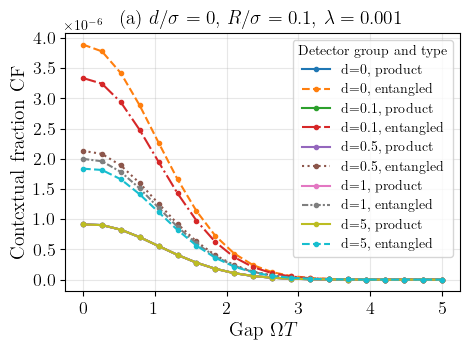

In [2]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

plt.figure(figsize=(4.8,3.6))

rho_types = [
              "product",
              "entangled"
        ]

# Sweep gaps
gaps = np.linspace(0.0, 5, 20)  # avoid zero to keep numerics well-behaved
deez = [0, 0.1, 0.5, 1, 5]

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1))]  # Add more if needed

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        # rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)
            label = f"d={d}, {rho_type}"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, marker=".", lw=1.5, label=label, linestyle=linestyle)

plt.xlabel(r"{Gap} $\Omega T$",fontsize=14)
plt.ylabel(r"{Contextual fraction} CF",fontsize=14)
plt.title(rf"(a) $d/\sigma={separation}$, $R/\sigma={smearing}$, $\lambda={lam}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(title="Detector group and type")
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()



## Contextual fraction vs gap ($\Omega$)
### ONLY FOR SU2

In [3]:
''' This cell generates the plots for contextual fraction for various detector types only for the SU(2) group. '''

# Fixed parameters
switching = 1.0
separation = 1.0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

# You can toggle these if you want SU2 instead
group = "SU2"            # or "SU2"
detector_type = "smeared"  # "point_like" or "smeared"

plt.figure(figsize=(4.8,3.6))

# Sweep gaps
gaps = np.linspace(0.1, 20, 100)  # avoid zero to keep numerics well-behaved
cf_vals = []

for gap in gaps:
    rho = detector_state(
        gap=gap,
        switching=switching,
        separation=gap,
        regulator=regulator,
        smearing=smearing,
        regularization=regularization,
        detector_type=detector_type,
        group=group,
        lam=lam,
    )
    if is_valid_state(rho):
        res = contextual_fraction(rho)
        if not res.get("success", False):
            cf_vals.append(np.nan)

        else:
            cf_vals.append(res.get("b", np.nan))
    else:
        print("Invalid state detected at gap =", gap)
        validate_and_print(rho)
        break #Print the details for the first invalid state and exit

cf_vals = np.array(cf_vals)#*(1/lam**2)

plt.plot(gaps, cf_vals, marker=".", lw=1.5)
plt.xlabel(r"{Gap} $\Omega T$",fontsize=14)
plt.ylabel(r"{Contextual fraction} CF",fontsize=14)
plt.title(rf"(a) $d/\sigma={separation}$, $R/\sigma={smearing}$, $\lambda={lam}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap.pdf")
plt.show()

KeyboardInterrupt: 

<Figure size 480x360 with 0 Axes>

## Contextual fraction vs switching (T)

In [ ]:
'''This cell generates the plots for contextual fraction vs switching for different detector types.'''


# Fixed parameters
gap = 1
separation = 10
smearing = 0.1
lam = 1e-3
regulator = 100
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

group_types = [
                #    ("SU2", "point_like"), 
                   ("SU2", "smeared"), 
                #    ("HW", "smeared")
              ]
labels = {
    # ("SU2", "point_like"): "SU(2), point like",
    ("SU2", "smeared"): "SU(2), smeared",
    # ("HW", "smeared"): "HW, smeared"
}

plt.figure(figsize=(4.8,3.6))

# Sweep gaps
switching_values = np.linspace(0.1, 5, 50)  # avoid zero to keep numerics well-behaved


for group, detector_type in group_types:
    cf_vals = []
    for switching in switching_values:
        rho = detector_state(
            gap=gap,
            switching=switching,
            separation=separation,
            regulator=regulator,
            smearing=smearing,
            regularization=regularization,
            detector_type=detector_type,
            group=group,
            lam=lam,
        )
        if is_valid_state(rho):
            res = contextual_fraction(rho)
            if not res.get("success", False):
                cf_vals.append(np.nan)
            else:
                cf_vals.append(res.get("b", np.nan))
        else:
            print("Invalid state detected at T =", switching)
            validate_and_print(rho)
            break

    cf_vals = np.array(cf_vals) #deleted division by lambda^2
    plt.plot(switching_values, cf_vals, marker=".", lw=1.5, label=labels[(group, detector_type)])


plt.xlabel(r" $\Omega T$",fontsize=14)
plt.ylabel(r"{Contextual fraction} CF",fontsize=14)
plt.title(rf"(a) $d\Omega={separation}$, $R\Omega={smearing}$, $\lambda={lam}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(title="Detector group and type")
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()



## Contextual fraction vs separation ($d$)


In [ ]:
'''This cell generates the plots for contextual fraction vs separation for different detector types.'''


# Fixed parameters
gap = 1.0
switching = 1.0
smearing = 0.01
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

group_types = [("SU2", "point_like"), ("SU2", "smeared"), ("HW", "smeared")]
labels = {
    ("SU2", "point_like"): "SU(2), point like",
    ("SU2", "smeared"): "SU(2), smeared",
    ("HW", "smeared"): "HW, smeared"
}

plt.figure(figsize=(4.8,3.6))

# Sweep gaps
separation_values = np.linspace(0.1, 5, 100)  # avoid zero to keep numerics well-behaved


for group, detector_type in group_types:
    cf_vals = []
    for separation in separation_values:
        rho = detector_state(
            gap=gap,
            switching=switching,
            separation=separation,
            regulator=regulator,
            smearing=smearing,
            regularization=regularization,
            detector_type=detector_type,
            group=group,
            lam=lam,
        )
        if is_valid_state(rho):
            res = contextual_fraction(rho)
            if not res.get("success", False):
                cf_vals.append(np.nan)
            else:
                cf_vals.append(res.get("b", np.nan))
        else:
            print("Invalid state detected at d =", separation)
            validate_and_print(rho)
            break

    cf_vals = np.array(cf_vals) #deleted division by lambda^2
    plt.plot(separation_values, cf_vals, marker=".", lw=1.5, label=labels[(group, detector_type)])


plt.xlabel(r"{Separation} $d/T$",fontsize=14)
plt.ylabel(r"{Contextual fraction} CF",fontsize=14)
plt.title(rf"(a) $d/T={separation}$, $R/T={smearing}$, $\lambda={lam}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(title="Detector group and type")
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()



## Contextual fraction vs smearing (R)

In [ ]:
'''This cell generates the plots for contextual fraction vs separation for different detector types.'''


# Fixed parameters
gap = 1.0
switching = 1.0
separation = 1.0
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

group_types = [("SU2", "point_like"), ("SU2", "smeared"), ("HW", "smeared")]
labels = {
    ("SU2", "point_like"): "SU(2), point like",
    ("SU2", "smeared"): "SU(2), smeared",
    ("HW", "smeared"): "HW, smeared"
}

plt.figure(figsize=(4.8,3.6))

# Sweep gaps
smearing_values = np.linspace(0.1, 5, 100)  # avoid zero to keep numerics well-behaved


for group, detector_type in group_types:
    cf_vals = []
    for smearing in smearing_values:
        rho = detector_state(
            gap=gap,
            switching=switching,
            separation=separation,
            regulator=regulator,
            smearing=smearing,
            regularization=regularization,
            detector_type=detector_type,
            group=group,
            lam=lam,
        )
        if is_valid_state(rho):
            res = contextual_fraction(rho)
            if not res.get("success", False):
                cf_vals.append(np.nan)
            else:
                cf_vals.append(res.get("b", np.nan))
        else:
            print("Invalid state detected at d =", separation)
            validate_and_print(rho)
            break

    cf_vals = np.array(cf_vals) #deleted division by lambda^2
    plt.plot(smearing_values, cf_vals, marker=".", lw=1.5, label=labels[(group, detector_type)])


plt.xlabel(r"{Smearing} $R/T$",fontsize=14)
plt.ylabel(r"{Contextual fraction} CF",fontsize=14)
plt.title(rf"(a) $d/\sigma={separation}$, $R/\sigma={smearing}$, $\lambda={lam}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(title="Detector group and type")
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()